# Environment Set Up

## Requirements

In [1]:
!pip install antspyx
!pip install -q matplotlib
!pip install -q "monai-weekly[nibabel, tqdm]"

## Imports

In [2]:
# System
import os
import time

# Data Load & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Monai
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import decollate_batch
from monai.utils import set_determinism
from monai.networks.nets import SegResNet
from monai.handlers.utils import from_engine
from monai.data import CacheDataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Invertd,
    Compose,
    Spacingd,
    RandFlipd,
    LoadImaged,
    AsDiscrete,
    AsDiscreted,
    Activations,
    EnsureTyped,
    Activationsd,
    Orientationd,
    MapTransform,
    RandSpatialCropd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    EnsureChannelFirstd,  
    ResizeWithPadOrCropd,
)

# PyTorch
import torch

## Collab Integration

In [3]:
# Check if CUDA is available
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

# Print the device
print(f"Device: {device}")

Running on GPU
Device: cuda


## Config

In [4]:
# Seeds
set_determinism(seed=33) # Monai
np.random.seed(33) # Numpy
torch.manual_seed(33) # PyTorch

# Others
%matplotlib inline

# Load Data

In [5]:
# Paths
root_dir = './data/'
images_dir = root_dir + 'UCSF_BrainMetastases_TRAIN/'

# Load Subjects Information
df = pd.read_excel(root_dir + 'TableS1_UCSF_BrainMetastases_SubjectInfo.xlsx')
df.drop(columns=['Unnamed: 13', 'BraTS_ID', 'TRAIN or TEST', 'Prior Craniotomy/Biopsy/Resection'], inplace=True)

# Split Train/Val/Test - 70%/10%/20%
df['split'] = np.random.choice(['train', 'test', 'val'], p=[.7, .2, .1], size=(len(df),))

# Shuffle data
df = df.sample(frac=1, random_state=33).reset_index(drop=True)

# Load Images/Segmentations Paths
df['T1pre'] = [images_dir + id + '/' + id + '_T1pre.nii.gz' for id in df['SubjectID']]
df['FLAIR'] = [images_dir + id + '/' + id + '_FLAIR.nii.gz' for id in df['SubjectID']]
df['T1post'] = [images_dir + id + '/' + id + '_T1post.nii.gz' for id in df['SubjectID']]
df['T2Synth'] = [images_dir + id + '/' + id + '_T2Synth.nii.gz' for id in df['SubjectID']]
df['BraTS-seg'] = [images_dir + id + '/' + id + '_BraTS-seg.nii.gz' for id in df['SubjectID']]

print('Total length of the dataframe:', len(df))

# Drop Subjects with no BraTS-seg annotation
for path in df['BraTS-seg']:
  if not os.path.isfile(path):
    df = df[df['BraTS-seg'] != path]

print('Lenght after dropping subject with no BraTS Segmentation Annotation:', len(df))

# Set index
df = df.set_index('SubjectID')

df

Total length of the dataframe: 461
Lenght after dropping subject with no BraTS Segmentation Annotation: 324


,Sex,Age,CancerType,ScannerType,Scanner Strength (Tesla),In-plane voxel size (mm),Slice Thickness (mm),Matrix size,NumberMetastases,VolumeMetastases_mm3,split,T1pre,FLAIR,T1post,T2Synth,BraTS-seg
SubjectID,,,,,,,,,,,,,,,,
100324A,Female,68,Lung,GE 1.5 T Signa HDxt,1.5,1.17x1.17,1.5,256x256x98,34,11080.871970,train,./data/UCSF_BrainMetastases_TRAIN/100324A/1003...,./data/UCSF_BrainMetastases_TRAIN/100324A/1003...,./data/UCSF_BrainMetastases_TRAIN/100324A/1003...,./data/UCSF_BrainMetastases_TRAIN/100324A/1003...,./data/UCSF_BrainMetastases_TRAIN/100324A/1003...
100279B,Female,71,Renal,GE 1.5 T Signa HDxt,1.5,0.86x0.86,1.5,256x256x104,18,6200.650296,train,./data/UCSF_BrainMetastases_TRAIN/100279B/1002...,./data/UCSF_BrainMetastases_TRAIN/100279B/1002...,./data/UCSF_BrainMetastases_TRAIN/100279B/1002...,./data/UCSF_BrainMetastases_TRAIN/100279B/1002...,./data/UCSF_BrainMetastases_TRAIN/100279B/1002...
100222B,Female,66,GU Fallopian,GE 1.5 T Signa HDxt,1.5,0.86x0.86,1.5,256x256x100,7,787.683109,train,./data/UCSF_BrainMetastases_TRAIN/100222B/1002...,./data/UCSF_BrainMetastases_TRAIN/100222B/1002...,./data/UCSF_BrainMetastases_TRAIN/100222B/1002...,./data/UCSF_BrainMetastases_TRAIN/100222B/1002...,./data/UCSF_BrainMetastases_TRAIN/100222B/1002...
100312A,Female,77,GU Urothelial,GE 3.0 T Discovery MR750,3.0,0.53x0.53,2.0,512x136x512,1,11564.154053,train,./data/UCSF_BrainMetastases_TRAIN/100312A/1003...,./data/UCSF_BrainMetastases_TRAIN/100312A/1003...,./data/UCSF_BrainMetastases_TRAIN/100312A/1003...,./data/UCSF_BrainMetastases_TRAIN/100312A/1003...,./data/UCSF_BrainMetastases_TRAIN/100312A/1003...
100174A,Male,57,Melanoma,GE 1.5 T Signa HDxt,1.5,0.86x0.86,1.5,256x256x116,4,1134.440933,test,./data/UCSF_BrainMetastases_TRAIN/100174A/1001...,./data/UCSF_BrainMetastases_TRAIN/100174A/1001...,./data/UCSF_BrainMetastases_TRAIN/100174A/1001...,./data/UCSF_BrainMetastases_TRAIN/100174A/1001...,./data/UCSF_BrainMetastases_TRAIN/100174A/1001...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100228A,Female,62,Breast,GE 1.5 T Signa HDxt,1.5,0.86x0.86,1.5,256x256x96,7,3242.684191,val,./data/UCSF_BrainMetastases_TRAIN/100228A/1002...,./data/UCSF_BrainMetastases_TRAIN/100228A/1002...,./data/UCSF_BrainMetastases_TRAIN/100228A/1002...,./data/UCSF_BrainMetastases_TRAIN/100228A/1002...,./data/UCSF_BrainMetastases_TRAIN/100228A/1002...
100137A,Female,73,GI Pancreatic,GE 1.5 T Signa HDxt,1.5,1.17x1.17,1.5,256x256x106,16,12436.368114,train,./data/UCSF_BrainMetastases_TRAIN/100137A/1001...,./data/UCSF_BrainMetastases_TRAIN/100137A/1001...,./data/UCSF_BrainMetastases_TRAIN/100137A/1001...,./data/UCSF_BrainMetastases_TRAIN/100137A/1001...,./data/UCSF_BrainMetastases_TRAIN/100137A/1001...
100233A,Male,58,Melanoma,GE 1.5 T Signa HDxt,1.5,1.17x1.17,1.5,256x256x128,2,111.241325,train,./data/UCSF_BrainMetastases_TRAIN/100233A/1002...,./data/UCSF_BrainMetastases_TRAIN/100233A/1002...,./data/UCSF_BrainMetastases_TRAIN/100233A/1002...,./data/UCSF_BrainMetastases_TRAIN/100233A/1002...,./data/UCSF_BrainMetastases_TRAIN/100233A/1002...


In [6]:
# BraTS Annotations Transform
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

# Define transforms
train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"], reader="NibabelReader"),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"], reader="NibabelReader"),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

In [7]:
# Definition of custom dataset
class UCSF_Dataset(CacheDataset):
    def __init__(self, images, labels, transform):
        self.images = list(zip(*images))
        self.labels = list(labels)
        self.transform = transform

        # ERASE
        self.images = self.images[:2]
        self.labels = self.labels[:2]

    def __getitem__(self, index):
        sample = {'image':[self.images[index][0], self.images[index][1], self.images[index][2], self.images[index][3]], 'label':self.labels[index]}
        return self.transform(sample)

    def __len__(self):
        return len(self.images)

# Train Dataset
train_images = [df['T1pre'][df['split']=='train'], df['FLAIR'][df['split']=='train'], df['T1post'][df['split']=='train'], df['T2Synth'][df['split']=='train']]
train_labels = df['BraTS-seg'][df['split']=='train']
train_dataset = UCSF_Dataset(train_images, train_labels, train_transform)

# Validation Dataset
val_images = [df['T1pre'][df['split']=='val'], df['FLAIR'][df['split']=='val'], df['T1post'][df['split']=='val'], df['T2Synth'][df['split']=='val']]
val_labels = df['BraTS-seg'][df['split']=='val']
val_dataset = UCSF_Dataset(val_images, val_labels, val_transform)

torch.Size([4, 220, 220, 144])


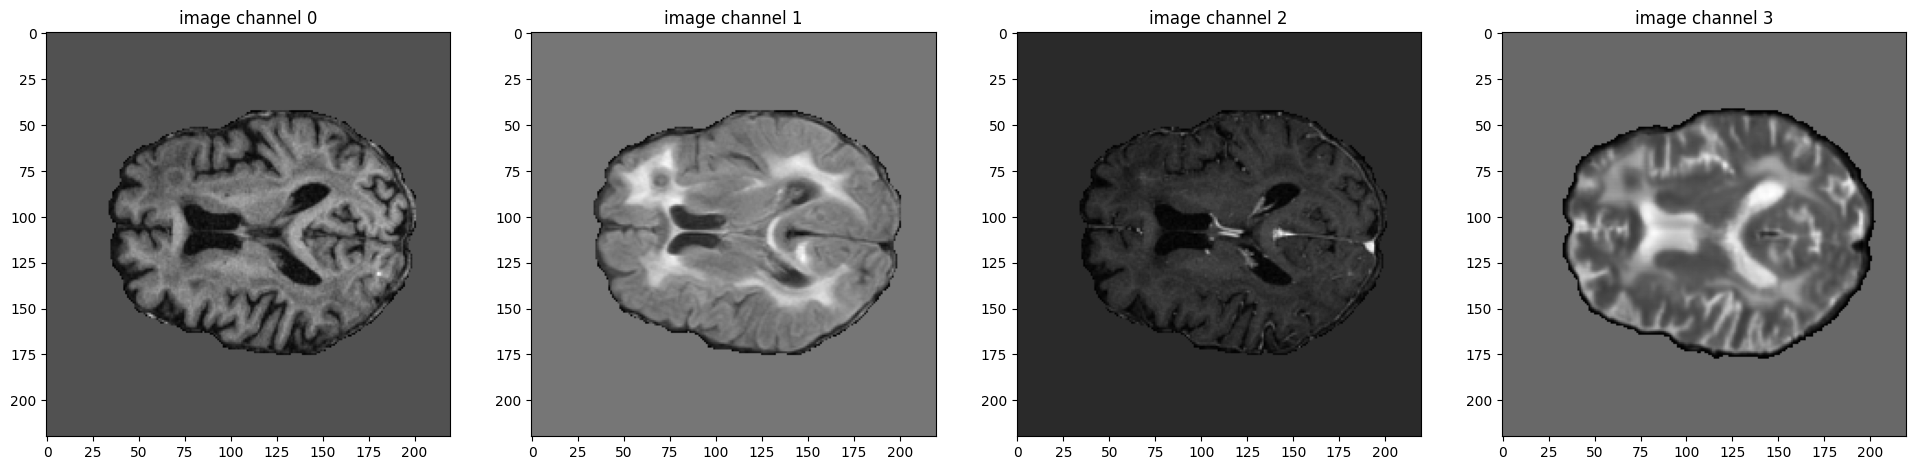

torch.Size([3, 224, 224, 144])


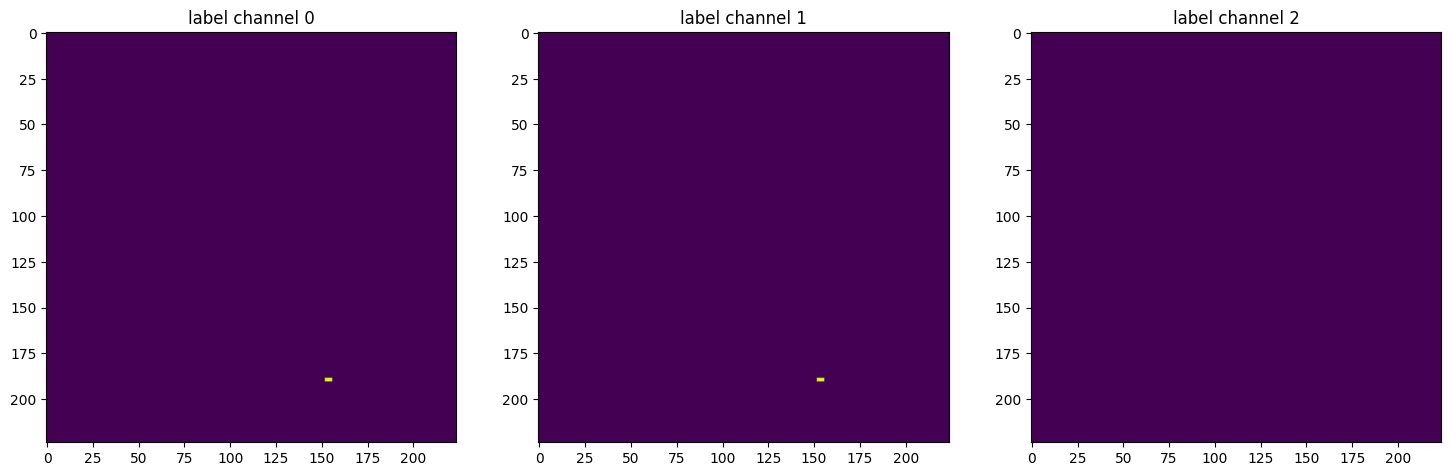

In [9]:
# Image
data = train_dataset[1]['image']
print(data.shape)
plt.figure("image", (24, 6))
for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(data[i, :, :, 70].detach().cpu(), cmap="gray")
plt.show()

# Label
label = train_dataset[0]['label']
print(label.shape)
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(label[i, :, :, 70].detach().cpu())
plt.show()

torch.Size([4, 220, 220, 188])


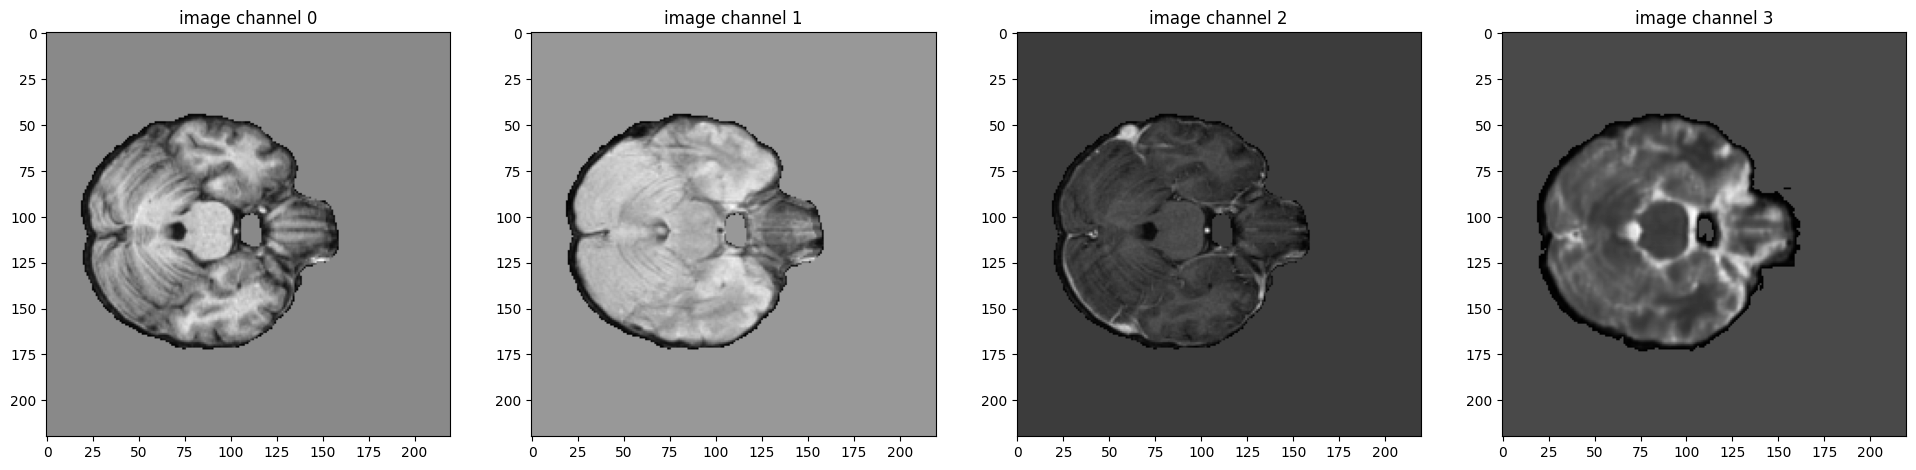

torch.Size([3, 220, 220, 188])


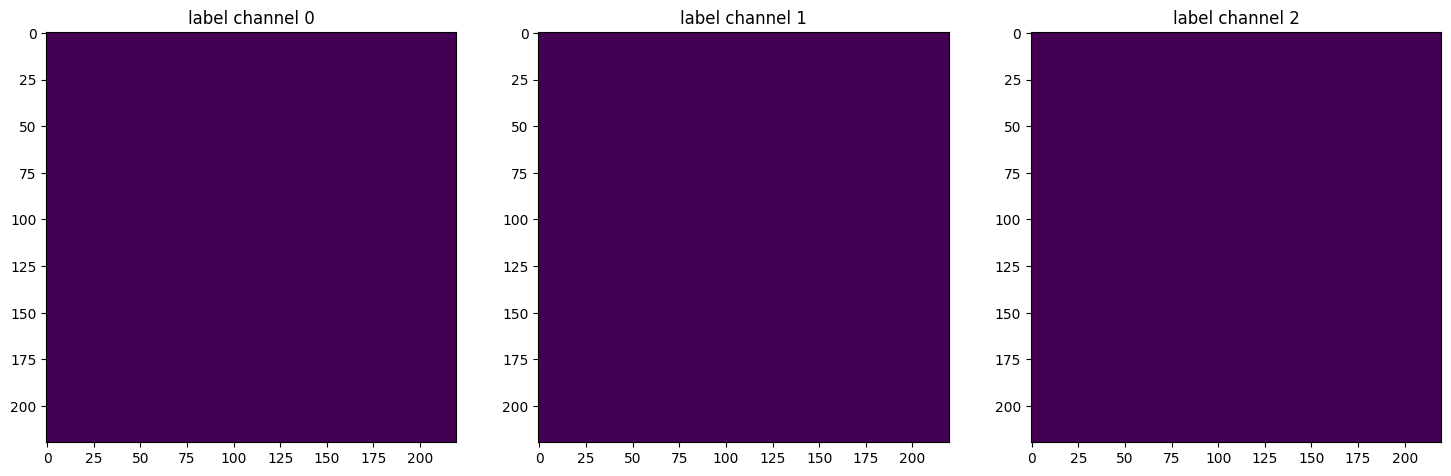

In [9]:
# Image
data = val_dataset[0]['image']
print(data.shape)
plt.figure("image", (24, 6))
for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(data[i, :, :, 70].detach().cpu(), cmap="gray")
plt.show()

# Label
label = val_dataset[0]['label']
print(label.shape)
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(label[i, :, :, 70].detach().cpu())
plt.show()

In [10]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [11]:
i = 0
for data in train_loader:
  if i == 3:
    break
  print(data['image'].shape)
  i+=1

torch.Size([1, 4, 224, 224, 144])


In [12]:
i = 0
for data in val_loader:
  if i == 3:
    break
  print(data['image'].shape)
  i+=1


torch.Size([1, 4, 220, 220, 188])


---
# TEMPLATE
---

## Create Model, Loss, Optimizer

In [13]:
max_epochs = 100
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

## Execute a typical PyTorch training process

In [14]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_dataset) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")

    # When epoch ends, clean GPU memory
    torch.cuda.empty_cache()
    
total_time = time.time() - total_start

----------
epoch 1/100
1/1, train_loss: 0.9821, step time: 155.6608
epoch 1 average loss: 0.9821
saved new best metric model
current epoch: 1 current mean dice: 0.0459 tc: 0.0115 wt: 0.0205 et: 0.1059
best mean dice: 0.0459 at epoch: 1
time consuming of epoch 1 is: 171.6624
----------
epoch 2/100
1/1, train_loss: 0.9781, step time: 36.6196
epoch 2 average loss: 0.9781
saved new best metric model
current epoch: 2 current mean dice: 0.0663 tc: 0.0144 wt: 0.0104 et: 0.1742
best mean dice: 0.0663 at epoch: 2
time consuming of epoch 2 is: 54.6406
----------
epoch 3/100
1/1, train_loss: 0.9736, step time: 34.2477
epoch 3 average loss: 0.9736
current epoch: 3 current mean dice: 0.0663 tc: 0.0247 wt: 0.0132 et: 0.1609
best mean dice: 0.0663 at epoch: 2
time consuming of epoch 3 is: 50.6973
----------
epoch 4/100
1/1, train_loss: 0.9699, step time: 34.4207
epoch 4 average loss: 0.9699
saved new best metric model
current epoch: 4 current mean dice: 0.1082 tc: 0.0256 wt: 0.0305 et: 0.2686
best me

In [15]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.2730 at epoch: 31, total time: 5037.381281852722.


## Plot the loss and metric

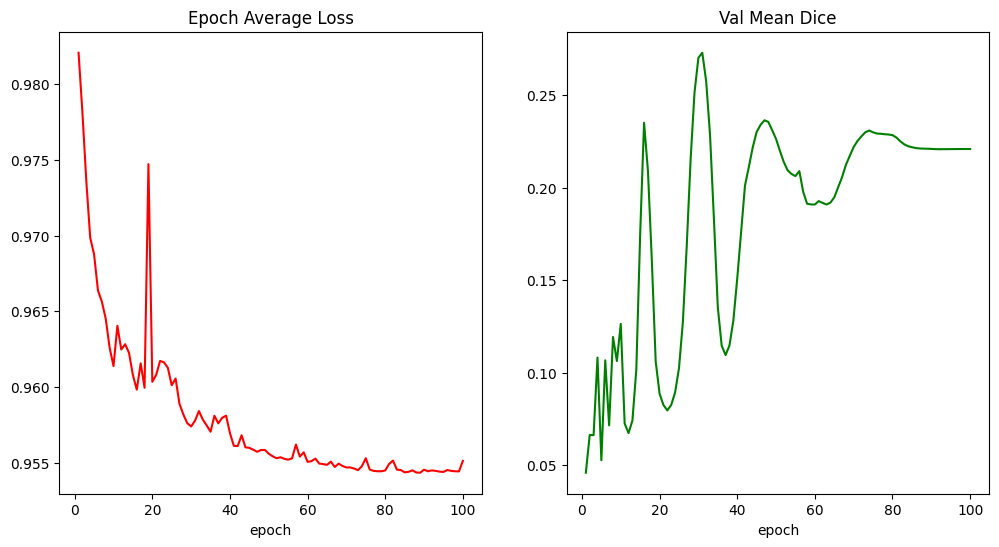

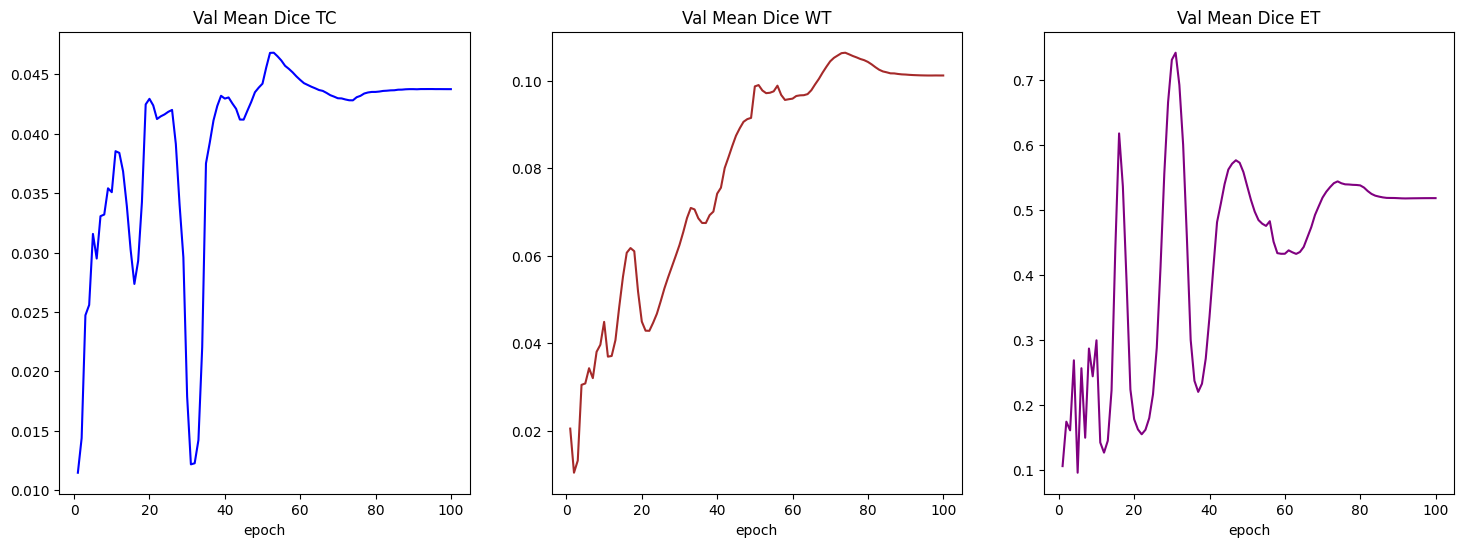

In [16]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

## Check best model output with the input image and label

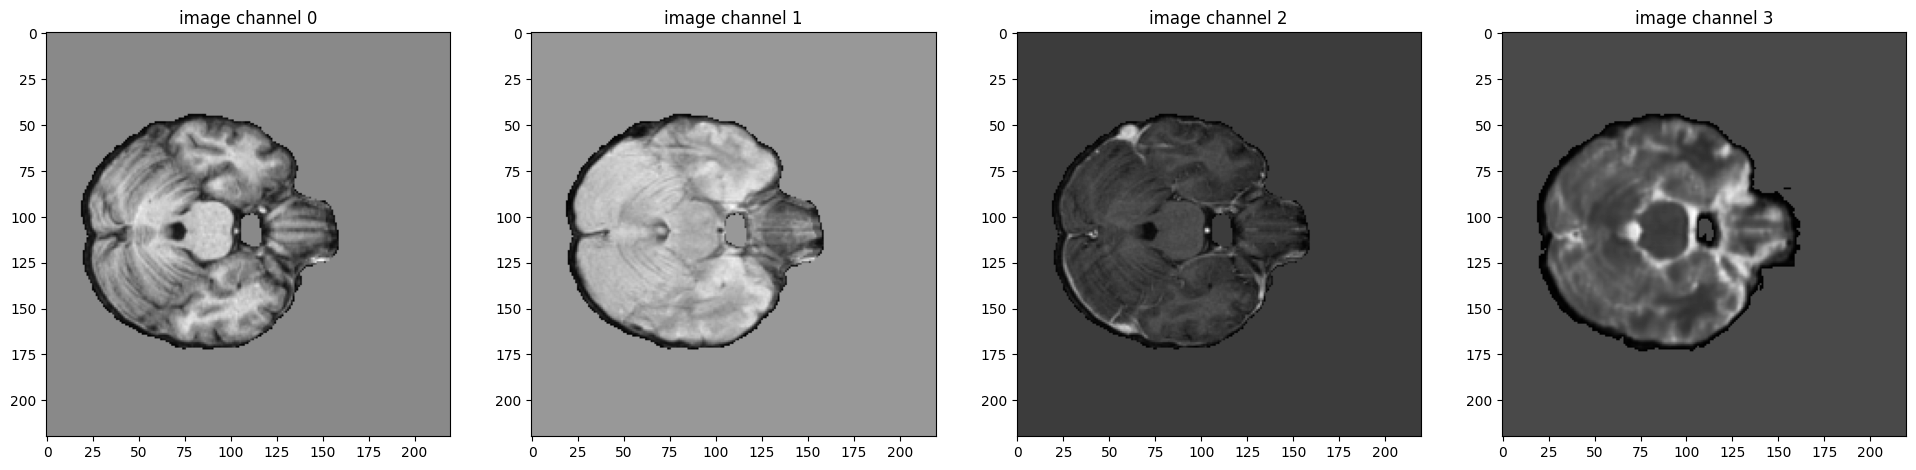

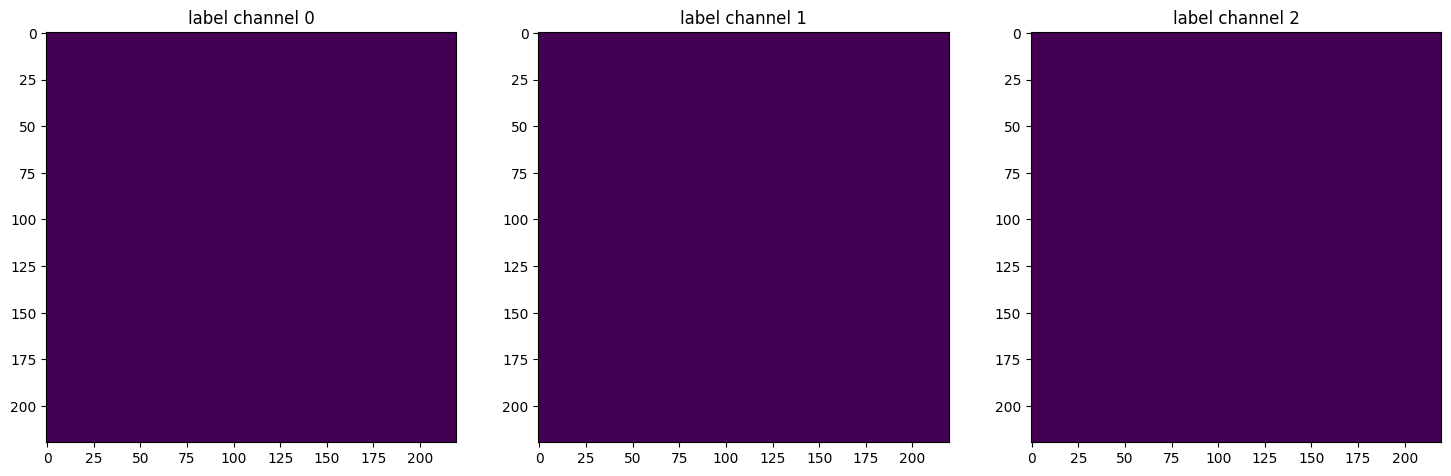

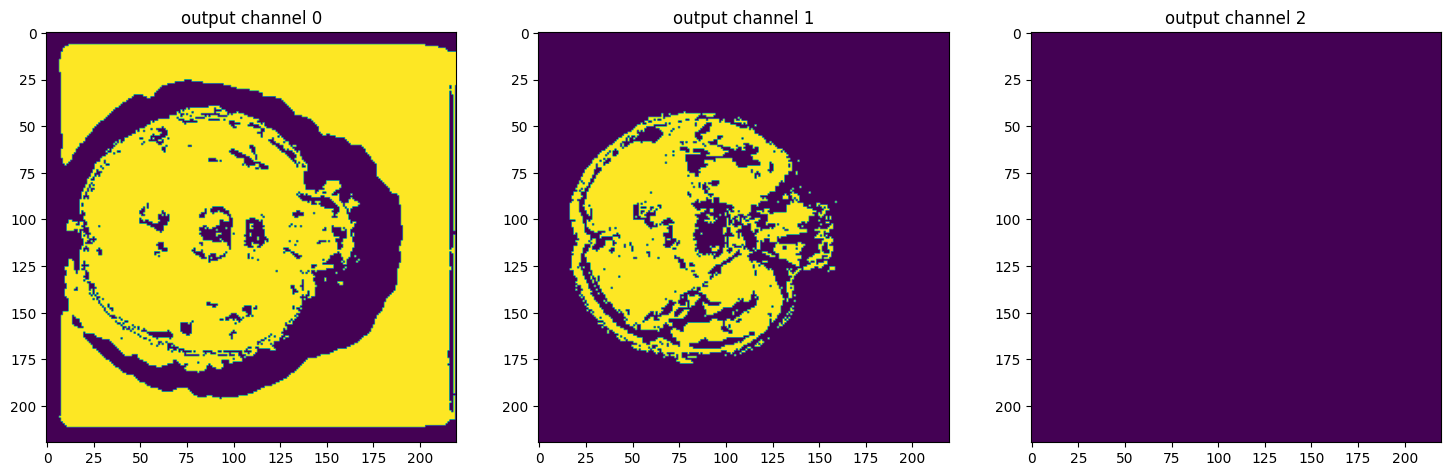

In [20]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_dataset[0]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_dataset[0]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_dataset[0]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

## Evaluation on original image spacings

In [18]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

val_org_dataset = UCSF_Dataset(val_images, val_labels, val_transform)
val_org_loader = DataLoader(val_org_dataset, batch_size=1, shuffle=False)

print(val_org_dataset[0])

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x000002AF2DC6F550>

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")